In [85]:
import modules.board_module as bf
import modules.tree_module as tf
import modules.stockfish_module as sf
from ModelSaver import ModelSaver
import random
from dataclasses import dataclass
from collections import namedtuple
import itertools
import time
import argparse
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from math import floor, ceil

# from train_nn_evaluator import EvalDataset

In [113]:
class EvalDataset(torch.utils.data.Dataset):

  def __init__(self, datapath, sample_names, indexes=None, log_level=1):
    """
    Dataset containint stockfish evaluations of chess positions. Pass in the
    path to the samples, their names, and the indexes to load
    """

    t1 = time.time()

    self.modelsaver = ModelSaver(datapath, log_level=log_level)
    self.log_level = log_level
    self.positions = []
    self.mate_value = 50000 # 50 pawns
    self.convert_evals_to_pawns = True
    self.use_all_moves = True
    self.use_eval_normalisation = False
    self.norm_method = "standard"
    self.norm_factor = None
    self.board_dtype = torch.float

    self.boards = []
    self.evals = []

    # automatically get all indexes if not specified
    if indexes is None:
      indexes = list(range(self.modelsaver.get_recent_file(name=sample_names, 
                                                           return_int=True) + 1))

    for ind in indexes:
      newdata = self.modelsaver.load(sample_names, id=ind)
      self.positions += newdata

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {len(indexes)} files loaded {t2 - t1:.2f} seconds")

  def __len__(self):
    return len(self.positions)
  
  def __getitem__(self, idx):
    if idx > len(self.positions):
      raise RuntimeError(f"EvalDataset.__getitem__() error: idx ({idx}) > number of samples (len{self.positions})")
    
    return self.positions[idx]
  
  def FEN_to_torch(self, fen_string, move=None):
    """
    Convert an FEN string into a torch tensor board representation
    """

    if move is None:
      boardvec = bf.FEN_to_board_vectors(fen_string)
    else:
      boardvec = bf.FEN_and_move_to_board_vectors(fen_string, move)

    tensortype = self.board_dtype

    t_wP = torch.tensor(boardvec.wP, dtype=tensortype).reshape(8, 8)
    t_wN = torch.tensor(boardvec.wN, dtype=tensortype).reshape(8, 8)
    t_wB = torch.tensor(boardvec.wB, dtype=tensortype).reshape(8, 8)
    t_wR = torch.tensor(boardvec.wR, dtype=tensortype).reshape(8, 8)
    t_wQ = torch.tensor(boardvec.wQ, dtype=tensortype).reshape(8, 8)
    t_wK = torch.tensor(boardvec.wK, dtype=tensortype).reshape(8, 8)
    t_bP = torch.tensor(boardvec.bP, dtype=tensortype).reshape(8, 8)
    t_bN = torch.tensor(boardvec.bN, dtype=tensortype).reshape(8, 8)
    t_bB = torch.tensor(boardvec.bB, dtype=tensortype).reshape(8, 8)
    t_bR = torch.tensor(boardvec.bR, dtype=tensortype).reshape(8, 8)
    t_bQ = torch.tensor(boardvec.bQ, dtype=tensortype).reshape(8, 8)
    t_bK = torch.tensor(boardvec.bK, dtype=tensortype).reshape(8, 8)
    t_wKS = torch.tensor(boardvec.wKS, dtype=tensortype).reshape(8, 8)
    t_wQS = torch.tensor(boardvec.wQS, dtype=tensortype).reshape(8, 8)
    t_bKS = torch.tensor(boardvec.bKS, dtype=tensortype).reshape(8, 8)
    t_bQS = torch.tensor(boardvec.bQS, dtype=tensortype).reshape(8, 8)
    t_colour = torch.tensor(boardvec.colour, dtype=tensortype).reshape(8, 8)
    t_total_moves = torch.tensor(boardvec.total_moves, dtype=tensortype).reshape(8, 8)
    t_no_take_ply = torch.tensor(boardvec.no_take_ply, dtype=tensortype).reshape(8, 8)

    board_tensor = torch.stack((
      t_wP,
      t_wN,
      t_wB,
      t_wR,
      t_wQ,
      t_wK,
      t_bP,
      t_bN,
      t_bB,
      t_bR,
      t_bQ,
      t_bK,
      t_wKS,
      t_wQS,
      t_bKS,
      t_bQS,
      t_colour,
      t_total_moves,
      t_no_take_ply,
    ), dim=0)

    return board_tensor
  
  def print_board_tensor(self, board_tensor):
    """
    Print the elements of the board tensor
    """

    print("Board tensor shape:", board_tensor.shape)
    print("White pawns", board_tensor[0])
    print("White knights", board_tensor[1])
    print("White bishops", board_tensor[2])
    print("White rooks", board_tensor[3])
    print("White queen", board_tensor[4])
    print("White king", board_tensor[5])
    print("Black pawns", board_tensor[6])
    print("Black knights", board_tensor[7])
    print("Black bishops", board_tensor[8])
    print("Black rooks", board_tensor[9])
    print("Black queen", board_tensor[10])
    print("Black king", board_tensor[11])
    print("White castles KS", board_tensor[12])
    print("White castles QS", board_tensor[13])
    print("Black castles KS", board_tensor[14])
    print("Black castles QS", board_tensor[15])
    print("colour", board_tensor[16])
    print("total moves", board_tensor[17])
    print("no take ply", board_tensor[18])

    return

  def normalise_evaluations(self):
    """
    Normalise the evaluations to zero mean and unit variance, and save the scaling
    """
    if self.norm_method == "minmax":
      max_value = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      self.norm_factor = max_value
      self.evals /= self.norm_factor
      if self.log_level > 0:
        print(f"Normalised evaluations, maximum value was {max_value}, now is {torch.max(-1 * torch.min(self.evals), torch.max(self.evals))}")
    
    elif self.norm_method == "standard":
      max_value = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      mean = self.evals.mean()
      std = self.evals.std()
      self.evals = (self.evals - mean) / std
      new_max = torch.max(-1 * torch.min(self.evals), torch.max(self.evals))
      self.evals /= new_max
      self.norm_factor = (new_max, mean, std)
      if self.log_level > 0:
        print(f"Normalised evaluations, max_value = {max_value:.3f} (max used = {new_max:.3f}), mean = {mean.item():.3f}, std = {std.item():.3f}, now max value is {torch.max(-1 * torch.min(self.evals), torch.max(self.evals)):.3f}, mean is {self.evals.mean().item():.3f} and std is {self.evals.std().item():.3f}")

  def denomormalise_evaluation(self, value=None, all=False):
    """
    Convert a single value back to regular units (or do it for all saved values)
    """

    if self.norm_method == "minmax":
      if all:
        self.evals *= self.norm_factor
      elif value is not None:
        return value * self.norm_factor
      else:
        raise RuntimeError("EvalDataset.denormalise_evaluations() error: all=False and value=None, incorrect function inputs")
    
    if self.norm_method == "standard":
      if all:
        self.evals = (self.evals * self.norm_factor[0] * self.norm_factor[2]) + self.norm_factor[1]
      elif value is not None:
        return (value * self.norm_factor[0] * self.norm_factor[2]) + self.norm_factor[1]
      else:
        raise RuntimeError("EvalDataset.denormalise_evaluations() error: all=False and value=None, incorrect function inputs")

  def to_torch(self):
    """
    Convert dataset into torch tensors
    """

    if len(self.positions) == 0:
      print("EvalDataset.to_torch() warning: len(self.positions) == 0, nothing done")
      return

    # get the shape of the board tensors
    example = self.FEN_to_torch(self.positions[0].fen_string)
    num_pos = len(self.positions)

    if self.use_all_moves:
      # count how many positions we will have
      num_lines = 0
      for i in range(num_pos):
        num_lines += len(self.positions[i].move_vector)
      self.boards = torch.zeros((num_lines, *example.shape), dtype=example.dtype)
      self.evals = torch.zeros(num_lines, dtype=torch.float)
      add_ind = 0
      error_moves = 0
      if self.log_level > 0:
        print(f"self.use_all_moves = True, found {num_lines} lines (emerging from {num_pos} positions)")
    else:
      self.boards = torch.zeros((num_pos, *example.shape), dtype=example.dtype)
      self.evals = torch.zeros(num_pos, dtype=torch.float)
    
    for i in range(num_pos):

      if self.use_all_moves:
        # loop through all moves and add those boards
        for j in range(len(self.positions[i].move_vector)):
          if self.positions[i].move_vector[j].move_letters == "pv":
            error_moves += 1
            num_lines -= 1
            continue
          self.boards[add_ind] = self.FEN_to_torch(self.positions[i].fen_string,
                                                   self.positions[i].move_vector[j].move_letters)
          if self.positions[i].move_vector[j].eval == "mate":
            if not bf.is_white_next_FEN(self.positions[i].fen_string):
              self.evals[add_ind] = -self.mate_value
            else:
              self.evals[add_ind] = self.mate_value
          else:
            self.evals[add_ind] = self.positions[i].move_vector[j].eval
          if self.convert_evals_to_pawns:
            self.evals[add_ind] *= 1e-3
          add_ind += 1

      else:
        self.boards[i] = self.FEN_to_torch(self.positions[i].fen_string)
        if self.positions[i].eval == "mate":
          if bf.is_white_next_FEN(self.positions[i].fen_string):
            self.evals[i] = -self.mate_value
          else:
            self.evals[i] = self.mate_value
        else:
          self.evals[i] = self.positions[i].eval
        if self.convert_evals_to_pawns:
          self.evals[i] *= 1e-3

    if self.use_all_moves:
      if error_moves > 0:
        self.boards = self.boards[:num_lines, :, :]
        self.evals = self.evals[:num_lines]
        if self.log_level > 0:
          print(f"The number of error moves was: {error_moves}, out of {num_lines + error_moves} lines. New vector length = {self.evals.shape}")

    # # for testing only
    # print("Shape of self.boards", self.boards.shape)
    # x = num_pos // 2
    # bf.print_FEN_board(self.positions[x].fen_string)
    # self.print_board_tensor(self.boards[x])

    if self.use_eval_normalisation:
      self.normalise_evaluations()

    return
  
  def check_duplicates(self, remove=False):
    """
    Check the number (and potentially remove) duplicates
    """

    t1 = time.time()

    # remove duplicates
    seen_values = set()
    unique_positions = []

    for position in self.positions:
      if position.fen_string not in seen_values:
        seen_values.add(position.fen_string)
        unique_positions.append(position)

    num_duplicates = len(self.positions) - len(unique_positions)

    # now if we want remove the duplicates
    if remove: self.positions = unique_positions

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {num_duplicates} duplicates found in {t2 - t1:.2f} seconds{', and removed' if remove else ''}")

    return num_duplicates
  
  def check_mate_positions(self, remove=False):
    """
    Check the number (and potentially remove) mate positions
    """

    t1 = time.time()

    no_mate_positions = []

    # loop backwards over all positions checking for mate
    for i in range(len(self.positions) - 1, -1, -1):
      if self.positions[i].eval != "mate":
        no_mate_positions.append(self.positions[i])

    num_mates = len(self.positions) - len(no_mate_positions)

    # now if we want remove the duplicates
    if remove: self.positions = no_mate_positions

    t2 = time.time()

    if self.log_level >= 1:
      print(f"EvalDataset(): {num_mates} mate positions found in {t2 - t1:.2f} seconds{', and removed' if remove else ''}")

    return num_mates


In [87]:
# load in the entire dataset
num_rand = 4096
datapath = "/home/luke/chess/python/gamedata/samples"
eval_file_template = "random_n={0}_sample"
inds = list(range(1))
log_level = 1
dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                      indexes=inds, log_level=log_level)

Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_110.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_001.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_002.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_003.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_004.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_005.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_006.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_007.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_008.lz4 with pickle ... finished
Loading file /home/luke/ches

In [102]:
print(f"Total number of positions = {len(dataset)}")
num_duplicates = dataset.check_duplicates()
num_mates = dataset.check_mate_positions()
print(f"Proportion of duplicates = {(num_duplicates / len(dataset))*100:.1f} %")
print(f"Proportion of mate positions = {(num_mates / len(dataset))*100:.1f} %")

# prepare the dataset
print("REMOVEING MATES AND DUPLICATES")
num_duplicates = dataset.check_duplicates(remove=True)
num_mates = dataset.check_mate_positions(remove=True)
dataset.board_dtype = torch.float
dataset.to_torch()

Total number of positions = 37447
EvalDataset(): 0 duplicates found in 0.02 seconds
EvalDataset(): 0 mate positions found in 0.02 seconds
Proportion of duplicates = 0.0 %
Proportion of mate positions = 0.0 %
REMOVEING MATES AND DUPLICATES
EvalDataset(): 0 duplicates found in 0.02 seconds, and removed
EvalDataset(): 0 mate positions found in 0.02 seconds, and removed
self.use_all_moves = True, found 1087464 lines (emerging from 37447 positions)


KeyboardInterrupt: 

In [108]:
savenew = False
savetorchonly = False

if savenew:

  dataset_name = "datasetv1"
  if savetorchonly: dataset_name += "_torch"

  datasaver = ModelSaver("/home/luke/chess/python/datasets/")

  for ind in range(11):

    print("Loading set", ind + 1, "/", 10)
    indexes = list(range(ind * 10 + 1, ((ind + 1) * 10) + 1))
    log_level = 1
    dataset = EvalDataset(datapath, eval_file_template.format(num_rand),
                          indexes=indexes, log_level=log_level)
    num_duplicates = dataset.check_duplicates(remove=True)
    num_mates = dataset.check_mate_positions(remove=True)
    dataset.board_dtype = torch.float
    dataset.to_torch()
    if savetorchonly:
      datasaver.save(dataset_name, [dataset.boards, dataset.evals])
    else:
      datasaver.save(dataset_name, dataset)

Loading set 1 / 10
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_001.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_002.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_003.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_004.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_005.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_006.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_007.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_008.lz4 with pickle ... finished
Loading file /home/luke/chess/python/gamedata/samples/random_n=4096_sample_009.lz4 with pickle ... finished
Loading f

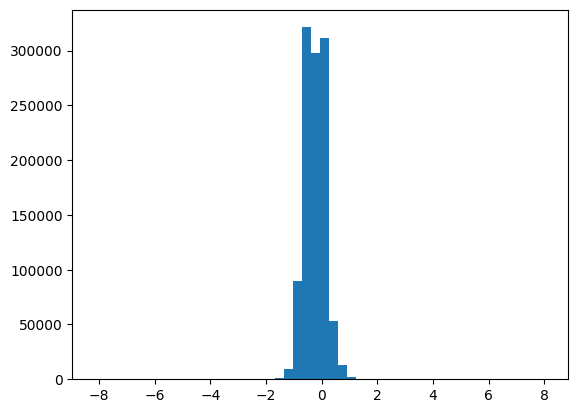

tensor(8.0530)
tensor(-8.1470)


In [109]:
fig, axs = plt.subplots(1, 1)
axs.hist(dataset.evals.numpy(), bins=50)
plt.show()

print(torch.max(dataset.evals))
print(torch.min(dataset.evals))

In [90]:
class BoardCNN(nn.Module):

  name = "BoardCNN"

  def __init__(self):

    super(BoardCNN, self).__init__()

    self.board_cnn = nn.Sequential(

      # Layer 1
      nn.Conv2d(in_channels=19, out_channels=32, kernel_size=3, padding=1),  # Conv layer
      nn.ReLU(),                                                             # Activation
      nn.MaxPool2d(kernel_size=2),                                           # Pooling (output size: 32 x 4 x 4)

      # Layer 2
      nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),                                           # Pooling (output size: 64 x 2 x 2)

      # Layer 3
      nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),                                           # Pooling (output size: 128 x 1 x 1)

      # Flatten layer to transition to fully connected
      nn.Flatten(),

      # two fully connected layers to produce a single output
      nn.Linear(128, 64),
      nn.ReLU(),
      nn.Linear(64, 1),
  )

  def forward(self, board):
    board = board.to(self.device)
    x = self.board_cnn(board)
    return x

In [91]:
class ResidualBlock(nn.Module):

  def __init__(self, in_channels, out_channels, stride = 1, downsample = None):

    super(ResidualBlock, self).__init__()
    
    self.conv1 = nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
      nn.BatchNorm2d(out_channels),
      nn.ReLU()
    )
    self.conv2 = nn.Sequential(
      nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
      nn.BatchNorm2d(out_channels)
    )

    self.downsample = downsample
    self.relu = nn.ReLU()
    self.out_channels = out_channels

  def forward(self, x):
    residual = x
    out = self.conv1(x)
    out = self.conv2(out)
    if self.downsample:
      residual = self.downsample(x)
    out += residual
    out = self.relu(out)
    return out
  
class ResNet(nn.Module):

  def __init__(self, block, layers, num_classes = 10):
    super(ResNet, self).__init__()
    self.inplanes = 64
    self.conv1 = nn.Sequential(
      nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
      nn.BatchNorm2d(64),
      nn.ReLU()
    )
    self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
    self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
    self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
    self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
    self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
    self.avgpool = nn.AvgPool2d(7, stride=1)
    self.fc = nn.Linear(512, num_classes)

  def _make_layer(self, block, planes, blocks, stride=1):
    downsample = None
    if stride != 1 or self.inplanes != planes:
      downsample = nn.Sequential(
          nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
          nn.BatchNorm2d(planes),
      )
    layers = []
    layers.append(block(self.inplanes, planes, stride, downsample))
    self.inplanes = planes
    for i in range(1, blocks):
      layers.append(block(self.inplanes, planes))

    return nn.Sequential(*layers)

  def forward(self, x):
    x = self.conv1(x)
    x = self.maxpool(x)
    x = self.layer0(x)
    x = self.layer1(x)
    x = self.layer2(x)
    x = self.layer3(x)

    x = self.avgpool(x)
    x = x.view(x.size(0), -1)
    x = self.fc(x)

    return x

class ChessNet(nn.Module):

  def __init__(self, in_channels):

    super(ChessNet, self).__init__()

    self.in_channels = in_channels
    c_in = in_channels

    self.board_cnn = nn.Sequential(
      ResidualBlock(c_in, c_in),
      ResidualBlock(c_in, c_in),
      ResidualBlock(c_in, c_in),
      nn.Sequential(nn.Flatten(), nn.Linear(c_in * 8 * 8, c_in), nn.ReLU()),
      nn.Linear(c_in, 1),
    )

  def forward(self, x):
    for l in self.layers:
      x = l(x)
    return x

In [92]:
def train(net, data_x, data_y, epochs=1, lr=5e-5, device="cuda"):
  """
  Perform a training epoch for a given network based on data inputs
  data_x, and correct outputs data_y
  """

  # move onto the specified device
  net.board_cnn.to(device)
  data_x = data_x.to(device)
  data_y = data_y.to(device)

  # put the model in training mode
  net.board_cnn.train()

  lossfcn = nn.MSELoss()
  optim = torch.optim.Adam(net.board_cnn.parameters(), lr=lr)

  batch_size = 64
  num_batches = len(data_x) // batch_size

  for i in range(epochs):

    print(f"Starting epoch {i + 1}. There will be {num_batches} batches")

    rand_idx = torch.randperm(data_x.shape[0])
    avg_loss = 0

    for n in range(num_batches):

      batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
      batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

      # use the model for a prediction and calculate loss
      net_y = net.board_cnn(batch_x)
      loss = lossfcn(net_y.squeeze(1), batch_y)

      # backpropagate
      loss.backward()
      optim.step()
      optim.zero_grad()

      avg_loss += loss.item()

      # if n % 500 == 0:
      #   print(f"Loss is {(avg_loss / (n + 1)) * 1000:.3f}, epoch {i + 1}, batch {n + 1} / {num_batches}")
    
    print(f"Loss is {(avg_loss / (num_batches * batch_size)) * 1000:.3f}, at end of epoch {i + 1}")

  return net

In [93]:
# for testing only
print("Shape of self.boards", dataset.boards.shape)
x = 0
# bf.print_FEN_board(dataset.positions[x].fen_string)
# dataset.print_board_tensor(dataset.boards[x])
print(f"Board evaluation: {dataset.evals[x]}")

# for j in range(len(dataset.positions[x].move_vector)):
#   print(dataset.positions[x].move_vector[j].eval)

Shape of self.boards torch.Size([1087462, 19, 8, 8])
Board evaluation: -0.049132201820611954


In [117]:
rexamine = False

if rexamine:

  # load all of the dataset files to examine the data distribution
  max_values = []
  mean_values = []
  std_values = []
  for i in range(1, 11):
    this_data = datasaver.load("datasetv1", id=i)
    this_data.normalise_evaluations()
    max_values.append(this_data.norm_factor[0])
    mean_values.append(this_data.norm_factor[1])
    std_values.append(this_data.norm_factor[2])

  true_max = np.max(max_values)
  avg_mean = np.mean(mean_values)
  avg_std = np.mean(std_values)

  print(f"True max = {true_max:.3f}, true mean = {avg_mean:.3f}, average std = {avg_std:.3f}")

  norm_factors = [true_max, avg_mean, avg_std]

else:
  # True max = 23.927, true mean = -0.240, average std = 0.355
  norm_factors = [23.927, -0.240, 0.355]


In [122]:
def normalise_data(data, factors):
  """
  Normalise data based on [max, mean, std]
  """
  max, mean, std = factors
  return ((data - mean) / std) / max

def denormalise_data(data, factors):
  """
  Undo normalisation based on [max, mean, std]
  """
  max, mean, std = factors
  return (data * max * std) + mean

def train_procedure(net, dataname, dataloader, data_inds, norm_factors,
                    epochs=1, lr=1e-7, device="cuda", batch_size=64,
                    loss_style="MSE"):
  """
  Perform a training epoch for a given network based on data inputs
  data_x, and correct outputs data_y
  """

  # move onto the specified device
  net.board_cnn.to(device)

  # put the model in training mode
  net.board_cnn.train()

  if loss_style.lower() == "mse":
    lossfcn = nn.MSELoss()
  elif loss_style.lower() == "l1":
    lossfcn = nn.L1Loss()
  elif loss_style.lower() == "huber":
    lossfcn == nn.HuberLoss()
  else:
    raise RuntimeError(f"train_procedure() error: loss_style = {loss_style} not recognised")

  optim = torch.optim.Adam(net.board_cnn.parameters(), lr=lr)
  
  # each epoch, cover the entire training dataset
  for i in range(epochs):

    print(f"Starting epoch {i + 1}.")
    total_batches = 0
    epoch_loss = 0

    # load the dataset in a series of slices
    for slice_num, j in enumerate(data_inds):

      # load this segment of the dataset
      dataset = dataloader.load(dataname, id=j)
      data_x = dataset.boards
      data_y = dataset.evals

      # normalise y labels
      data_y = normalise_data(data_y, norm_factors)

      num_batches = len(data_x) // batch_size
      total_batches += num_batches
      rand_idx = torch.randperm(data_x.shape[0])
      avg_loss = 0

      print(f"Starting slice {slice_num + 1} / {len(data_inds)}. There will be {num_batches} batches. ", end="", flush=True)

      # iterate through each batch for this slice of the dataset
      for n in range(num_batches):

        batch_x = data_x[rand_idx[n * batch_size : (n+1) * batch_size]]
        batch_y = data_y[rand_idx[n * batch_size : (n+1) * batch_size]]

        # go to cuda
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)

        # use the model for a prediction and calculate loss
        net_y = net.board_cnn(batch_x)
        loss = lossfcn(net_y.squeeze(1), batch_y)

        # backpropagate
        loss.backward()
        optim.step()
        optim.zero_grad()

        avg_loss += loss.item()

        # if n % 500 == 0:
        #   print(f"Loss is {(avg_loss / (n + 1)) * 1000:.3f}, epoch {i + 1}, batch {n + 1} / {num_batches}")

      # this dataset slice is finished
      epoch_loss += avg_loss
      avg_loss = avg_loss / num_batches
      avg_loss = avg_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
      print(f"Loss is {avg_loss:.3f}, during epoch {i + 1}, slice {slice_num + 1} / {len(data_inds)}", flush=True)
  
    # this epoch is finished
    epoch_loss = epoch_loss / total_batches
    epoch_loss = epoch_loss ** 0.5 * norm_factors[0] * norm_factors[2] # try to scale to original units
    print(f"Epoch {i + 1} has finished after {total_batches} batches. Overall average loss = {epoch_loss:.3f}", flush=True)

  # finally, return the network that we have trained
  return net

do_train_procedure = True

if do_train_procedure:

  net = ChessNet(19)

  device = "cuda"
  epochs = 10
  data_inds = list(range(1, 11))
  lr = 1e-7

  trained_net = train_procedure(
    net=net,
    dataname="datasetv1",
    dataloader=ModelSaver("/home/luke/chess/python/datasets/", log_level=1),
    data_inds=list(range(1, 11)),
    norm_factors=[23.927, -0.240, 0.355], # [max, mean, std]
    epochs=epochs,
    lr=lr,
    device=device    
  )

Starting epoch 1.
Loading file /home/luke/chess/python/datasets/datasetv1_001.lz4 with pickle ... finished
Starting slice 1 / 10. There will be 16938 batches. Loss is -0.873, during epoch 1, slice 1 / 10
Loading file /home/luke/chess/python/datasets/datasetv1_002.lz4 with pickle ... finished
Starting slice 2 / 10. There will be 17191 batches. Loss is -0.466, during epoch 1, slice 2 / 10
Loading file /home/luke/chess/python/datasets/datasetv1_003.lz4 with pickle ... finished
Starting slice 3 / 10. There will be 17133 batches. Loss is -0.301, during epoch 1, slice 3 / 10
Loading file /home/luke/chess/python/datasets/datasetv1_004.lz4 with pickle ... finished
Starting slice 4 / 10. There will be 16969 batches. Loss is -0.250, during epoch 1, slice 4 / 10
Loading file /home/luke/chess/python/datasets/datasetv1_005.lz4 with pickle ... finished
Starting slice 5 / 10. There will be 17140 batches. Loss is -0.242, during epoch 1, slice 5 / 10
Loading file /home/luke/chess/python/datasets/datase

KeyboardInterrupt: 

In [94]:
test_training = False

if test_training:

  # net = BoardCNN()
  net = ChessNet(19)

  device = "cuda"
  epochs = 10
  lr = 1e-7

  # # normalise the evaluations
  # print(torch.min(dataset.evals))
  # print(torch.max(dataset.evals))
  # dataset.evals /= torch.max(dataset.evals)
  print(torch.min(dataset.evals))
  print(torch.max(dataset.evals))

  trained_net = train(net, dataset.boards, dataset.evals, device=device, epochs=epochs, lr=lr)
  modelsaver = ModelSaver("/home/luke/chess/python/models/")
  modelsaver.save("eval_model", trained_net)

tensor(-0.9692)
tensor(1.)
Starting epoch 1. There will be 16991 batches


Loss is 8.075, at end of epoch 1
Starting epoch 2. There will be 16991 batches
Loss is 2.674, at end of epoch 2
Starting epoch 3. There will be 16991 batches
Loss is 2.321, at end of epoch 3
Starting epoch 4. There will be 16991 batches
Loss is 2.200, at end of epoch 4
Starting epoch 5. There will be 16991 batches
Loss is 2.124, at end of epoch 5
Starting epoch 6. There will be 16991 batches
Loss is 2.067, at end of epoch 6
Starting epoch 7. There will be 16991 batches
Loss is 2.024, at end of epoch 7
Starting epoch 8. There will be 16991 batches
Loss is 1.991, at end of epoch 8
Starting epoch 9. There will be 16991 batches
Loss is 1.962, at end of epoch 9
Starting epoch 10. There will be 16991 batches
Loss is 1.940, at end of epoch 10
Saving file /home/luke/chess/python/models/eval_model_016.lz4 with pickle ... finished


'/home/luke/chess/python/models/eval_model_016.lz4'

In [98]:
loss = 2.0 / 64
equiv = dataset.denomormalise_evaluation(value=loss)
print(f"A loss of {loss} corresponds to an average evaluation error of {equiv:.3f}")

A loss of 0.03125 corresponds to an average evaluation error of -0.147


In [99]:
avg_diff = 0
n = 100
for i in range(n):
  sf_eval = dataset.positions[i].eval
  net_eval = trained_net.board_cnn(dataset.boards[i].to(device).unsqueeze(dim=0))
  net_eval = net_eval.to("cpu").item()
  if dataset.use_eval_normalisation:
    net_eval = dataset.denomormalise_evaluation(value=net_eval)
  diff = abs(sf_eval*1e-3 - net_eval)
  avg_diff += diff
  # print(f"sf_eval = {sf_eval * 1e-3:.3f}, net_eval = {net_eval:.3f}, difference is {diff:.3f}")

print(f"The average difference from {n} samples is {avg_diff / n:.3f}")

The average difference from 100 samples is 0.472


In [96]:
extend_training = False

if extend_training:

  more_epochs = 10
  new_lr = 1e-8
  trained_net = train(trained_net, dataset.boards, dataset.evals, device=device, epochs=more_epochs, lr=new_lr)
  modelsaver = ModelSaver("/home/luke/chess/python/models/")
  modelsaver.save("eval_model", trained_net)

Starting epoch 1. There will be 16991 batches


KeyboardInterrupt: 